<a href="https://colab.research.google.com/github/anubhavgupta1/DeepLearning/blob/master/7_Vectorisation_of__Gradient_Descent_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Publisher : Anubhav Gupta
Contact : anubhav.gupta62@gmail.com, +91- 90418 -28524

**OUTLINE**

1. Modified SN Class
2. Overall setup - What is data, model task
3. Plotting Functions - 3d, Contour
4. Individual algorithms and how they perform



In [0]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from IPython.display import HTML

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import imageio
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs



![alt text](https://drive.google.com/uc?id=1Wnpd44PTe27Hcxv_5m2hGfv3ef7i00dI)

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])


In [0]:
np.random.seed(0)

In [0]:
class SN:

  def __init__(self,w_init,b_init,algo):
    self.w = w_init
    self.b = b_init
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.algo = algo

  def sigmoid(self,x,w=None,b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    return 1.0/(1.0 + np.exp(-(w*x + b )))
  
  def error(self,X,Y,w=None,b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    err = 0
    for x,y in zip(X,Y):
      err += 0.5 * (self.sigmoid(x,w,b)-y) ** 2
    return err
  
  def grad_w(self,x,y,w=None,b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x,w,b)
    return (y_pred - y) * y_pred * (1-y_pred) * x
  
  def grad_b(self,x,y,w=None,b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x,w,b)
    return (y_pred - y) * y_pred * (1-y_pred)
  
  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X,self.Y)) 
  
  def fit(self, X,Y,epochs =100, eta = 0.01,gamma = 0.9,mini_batch_size = 100, eps= 1e-8, beta = 0.9, beta1 = 0.9,beta2=0.9 ):
    self.w_h = []
    self.b_h = []
    self.e_h = []
    self.X = X
    self.Y = Y

    if self.algo == 'GD':
      for i in range(epochs):
        dw , db = 0 , 0
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        
        m = X.shape[0]
        self.w -= eta * (dw/m)
        self.b -= eta * (db/m)
        self.append_log()

    elif self.algo == 'MOMENTUM':
      v_w_prev, v_b_prev = 0,0
      for i in range(epochs):
        dw , db = 0 , 0
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        
        m = X.shape[0]
        v_w = gamma * v_w_prev + eta * (dw/m)
        v_b = gamma * v_b_prev + eta * (db/m)
        self.w -= v_w
        self.b -= v_b
        v_w_prev = v_w
        v_b_prev = v_b
        self.append_log()

    elif self.algo == 'NAG':
      v_w_prev, v_b_prev = 0,0
      for i in range(epochs):
        dw , db = 0 , 0
        v_w = gamma * v_w_prev  
        v_b = gamma * v_b_prev
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y,self.w - v_w,self.b - v_b)
          db += self.grad_b(x,y,self.w - v_w,self.b - v_b)
        
        m = X.shape[0]
        v_w = gamma * v_w_prev + eta * (dw/m)
        v_b = gamma * v_b_prev + eta * (db/m)
        self.w -= v_w
        self.b -= v_b
        v_w_prev = v_w
        v_b_prev = v_b
        self.append_log()

    elif self.algo == 'MiniBatch':
      for i in range(epochs):
        dw , db = 0 , 0
        points_seen = 0 
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          points_seen += 1
          if points_seen % mini_batch_size == 0:
            self.w -= eta * (dw/mini_batch_size)
            self.b -= eta * (db/mini_batch_size)
            self.append_log()
            dw , db = 0 , 0

    elif self.algo == 'AdaGrad':
      v_w,v_b = 0,0
      for i in range(epochs):
        dw , db = 0 , 0
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        v_w += dw ** 2
        v_b += db ** 2
        m_w = np.sqrt(v_w) + eps
        m_b = np.sqrt(v_b) + eps
        self.w -= eta * (dw/m_w)
        self.b -= eta * (db/m_b)
        self.append_log() 

    elif self.algo == 'RMSProp':
      v_w,v_b = 0,0
      for i in range(epochs):
        dw , db = 0 , 0
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
        v_w = beta* v_w + (1 - beta) * (dw ** 2)
        v_b = beta* v_b + (1 - beta) * (db ** 2)
        m_w = np.sqrt(v_w) + eps
        m_b = np.sqrt(v_b) + eps
        self.w -= eta * (dw/m_w)
        self.b -= eta * (db/m_b)
        self.append_log()

    elif self.algo == 'Adam':
      v_w,v_b = 0,0
      m_w,m_b = 0,0
      num_updates = 0
      for i in range(epochs):
        dw , db = 0 , 0
        for x , y in zip(X,Y):
          dw += self.grad_w(x,y)
          db += self.grad_b(x,y)
          num_updates += 1
          m_w = beta1 * m_w + (1 - beta1) * (dw)
          m_b = beta1 * m_b + (1 - beta1) * (db)
          v_w = beta2 * v_w + (1 - beta2) * (dw ** 2)
          v_b = beta2 * v_b + (1 - beta2) * (db ** 2)
          m_w_c = m_w / (1-np.power(beta1,num_updates))
          m_b_c = m_b / (1-np.power(beta1,num_updates))
          v_w_c = v_w / (1-np.power(beta2,num_updates))
          v_b_c = v_b / (1-np.power(beta2,num_updates))
          n_w = np.sqrt(v_w_c) + eps
          n_b = np.sqrt(v_b_c) + eps
          self.w -= eta * (m_w_c/n_w)
          self.b -= eta * (m_b_c/n_b)
          self.append_log()      



In [0]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

#algo = 'RMSProp'
algo = 'Adam'

w_init = -6
b_init = 4.0


epochs = 200
eta = 0.5
gamma = 0.9
mini_batch_size = 6
beta1 = 0.9
beta2 = 0.9

w_min = -7
w_max = 5
eps = 1e-8

b_min = -5
b_max = 5

animation_frames = 20

plot_2d = True
plot_3d = False

#Adgrad and NAG


X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])


Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])


algo = 'NAG'

algo = 'AdaGrad'


w_init = -6
b_init = 4.0

epochs = 200
epochs = 100
eta = 0.5
gamma = 0.9
mini_batch_size = 6

w_min = -7
w_max = 5
eps = 1e-8

b_min = -5
b_max = 5

animation_frames = 20

plot_2d = True
plot_3d = False



#RmsProp and Adagrad


X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

algo = 'AdaGrad'
algo = 'RmsProp'


w_init = -6
b_init = 4.0


epochs = 100
eta = 0.1
gamma = 0.9
mini_batch_size = 6

w_min = -7
w_max = 5
eps = 1e-8

b_min = -5
b_max = 5

animation_frames = 20

plot_2d = True
plot_3

RmsProp does a weighted accumulation of old and current updates

#Adam and RmsProp
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

algo = 'RMSProp'
algo = 'Adam'

w_init = -6
b_init = 4.0


epochs = 200
eta = 0.5
gamma = 0.9
mini_batch_size = 6
beta1 = 0.9
beta2 = 0.9

w_min = -7
w_max = 5
eps = 1e-8

b_min = -5
b_max = 5

animation_frames = 20

plot_2d = True
plot_3d = False

Adam Solves the drawback of RMSProp by having momentum component

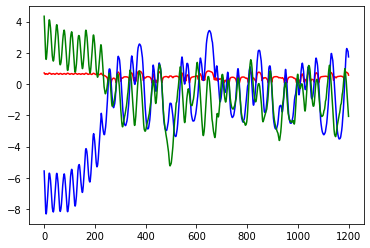

In [38]:
sn = SN(w_init,b_init,algo)
sn.fit(X,Y,epochs = epochs, eta = eta,gamma=gamma,mini_batch_size=mini_batch_size,eps=eps,beta1=beta1,beta2=beta2)
plt.plot(sn.e_h,'r')
plt.plot(sn.w_h,'b')
plt.plot(sn.b_h,'g')
w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
#plt.plot(w_diff, 'b--')
#plt.plot(b_diff, 'g--')
plt.show()

In [0]:
def plot_animate_3d(i):
  i = int(i*(epochs/animation_frames))
  line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line1.set_3d_properties(sn.e_h[:i+1])
  line2.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  line2.set_3d_properties(np.zeros(i+1) - 1)
  title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  return line1, line2, title

In [0]:
if plot_3d: 
  W = np.linspace(w_min, w_max, 256)
  b = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, b)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100) #no. of dots in plot  
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(WW, BB, Z, rstride=3, cstride=3, alpha=0.5, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  cset = ax.contourf(WW, BB, Z, 25, zdir='z', offset=-1, alpha=0.6, cmap=cm.coolwarm)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  ax.set_zlabel('error')
  ax.set_zlim(-1, np.max(Z))
  ax.view_init (elev=25, azim=-75) # azim = -20
  ax.dist=12  
  title = ax.set_title('Epoch 0')

We want to move from dark red to blue valley

In [0]:
if plot_3d: 
  i = 0
  line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], sn.e_h[:i+1], color='black',marker='.')
  line2, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], np.zeros(i+1) - 1, color='red', marker='.')
  anim = animation.FuncAnimation(fig, func=plot_animate_3d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim

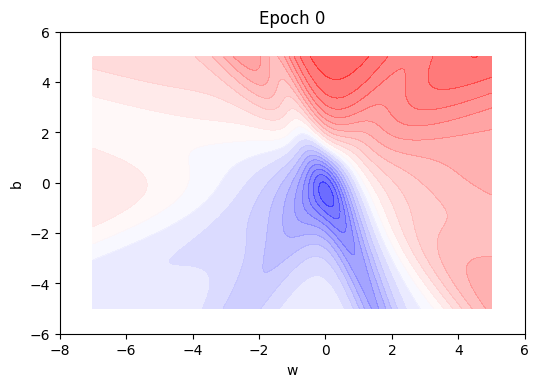

In [42]:
if plot_2d: 
  W = np.linspace(w_min, w_max, 256)
  b = np.linspace(b_min, b_max, 256)
  WW, BB = np.meshgrid(W, b)
  Z = sn.error(X, Y, WW, BB)

  fig = plt.figure(dpi=100)
  ax = plt.subplot(111)
  ax.set_xlabel('w')
  ax.set_xlim(w_min - 1, w_max + 1)
  ax.set_ylabel('b')
  ax.set_ylim(b_min - 1, b_max + 1)
  title = ax.set_title('Epoch 0')
  cset = plt.contourf(WW, BB, Z, 25, alpha=0.6, cmap=cm.bwr)
  plt.show()

In [0]:
def plot_animate_2d(i):
  i = int(i*(epochs/animation_frames))
  line.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
  title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
  return line, title

In [0]:
if plot_2d: 
  i = 0
  line, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], color='black',marker='.')
  anim = animation.FuncAnimation(fig, func=plot_animate_2d, frames=animation_frames)
  rc('animation', html='jshtml')
  anim

In [45]:
if algo == 'GD':
  print('algo = {}, eta = {}'.format(algo, eta))
elif algo == 'Momentum' or algo == 'NAG':
  print('algo = {}, eta = {}, gamma = {}'.format(algo, eta, gamma))
elif algo == 'MiniBatch':
  print('algo = {}, eta = {}, batch size = {}'.format(algo, eta, mini_batch_size))
elif algo == 'AdaGrad' or algo == 'RMSProp':
  print('algo = {}, eta = {}, eps = {}'.format(algo, eta, eps))
anim

GD and Momentum Inputs

X = np.asarray([0.5,2.5])

Y = np.asarray([0.2,0.9])

Gradient descent
#(W_init = -2, B_init = -2, epochs = 1000, algo 'GD' )
#(W_init = -3, B_init = 4, epochs = 1000, algo 'GD' )
#(W_init = -5, B_init = 4, epochs = 1000, algo 'GD' )
#(W_init = -4, B_init = 0, epochs = 1000, algo 'GD' )
#(W_init = -4, B_init = 0, epochs = 5000, algo 'GD' )
#(W_init = -4, B_init = 0, epochs = 10000, algo 'GD' )
Will increasing the epochs of training solve the problem of getting stuck at local optima?

Case1: Surely with more epochs the solution will move out of local optima and move to global optima.

Case2 : No, since the gradients are infinitesimal (very small) therefore the weights will not be updated irrespective number of epochs.

Ans : Both cases are possible it entire depends upon the nature of the surface where the solution is stuck. 

Drawback :
1. In regions of low gradients, its not able to reinforce the direction it should move. So, we move to momentum. 


Momentum

Drawback: 
#(W_init = -4, B_init = 0, epochs = 1000, algo 'Momentum' )
1. It causes overshooting with large and continuous increase in gradient along a direction. (overshoot and comeback)

#(W_init = -4, B_init = 0, epochs = 1000, algo 'Momentum', gamma = 0.8 )
2. It controls the speed of momentum


#(W_init = -3, B_init = 4, epochs = 1000, algo 'GD' )
#(W_init = -3, B_init = 4, epochs = 1000, algo 'Momentum' )
3. Overshooting Problem. In case of too many contour lines GD works better than momentum.

NAG 

Inputs:

X = np.asarray([3.5, 0.35, 3.2])

Y = np.asarray([0.49, 0.53, 0.52])

#(W_init = 2.1, B_init = 4.0, epochs = 1000, algo 'Momentum' )
1. In valley Oscillations are very large. 
#(W_init = 2.1, B_init = 4.0, epochs = 1000, algo 'NAG' )
2. Faster convergance and Reduced Overshoots.

GD and MiniBatch GD

Inputs for mini and adagrad

X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])

Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

mini_batch_size = 1
gamma = 0.9

#(W_init = 2.1, B_init = 4.0, epochs = 1000, algo 'MiniBatch' )
1. Lots of oscillations that filled color green.

All same 

mini_batch_size = 2
2. Lesser magnitude of oscillations or noise



mini_batch_size = 3
3. Lesser magnitude of oscillations or noise



mini_batch_size = 6
4. It becomes case of GD


5. If we make more updates then we need fewer number of epochs.
6. If I have large no. of data that probably may not fit, so it is better to divide data into batches. 


Adagrad

#(W_init = -6, B_init = 4, epochs = 1000, algo 'NAG' )
#(W_init = -6, B_init = 4, epochs = 1000, algo 'AdaGrad' )

#Generation of Data

In [73]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


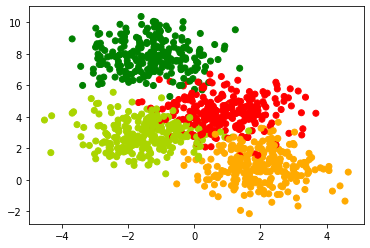

In [74]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

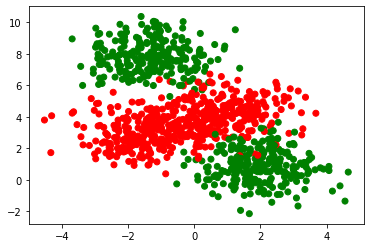

In [76]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [77]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [78]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [79]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[0.76103773 0.12167502]
 [0.44386323 0.33367433]]
[[ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]]


In [0]:
class FFNetwork:
  
  def __init__(self, W1, W2):
        
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,4))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
      
  def grad_activation(self, X):
    return X*(1-X) 

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      plt.plot(list(loss.values()), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [0]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

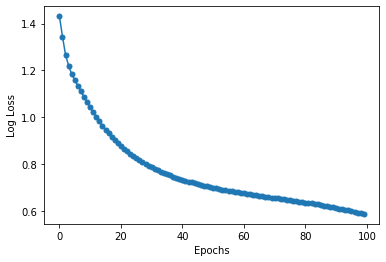

Training accuracy 0.8627
Validation accuracy 0.88
CPU times: user 324 ms, sys: 6.65 ms, total: 331 ms
Wall time: 345 ms


In [84]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

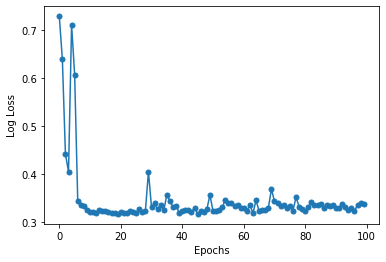

Training accuracy 0.8667
Validation accuracy 0.872
CPU times: user 1.05 s, sys: 8.93 ms, total: 1.06 s
Wall time: 1.06 s


In [85]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

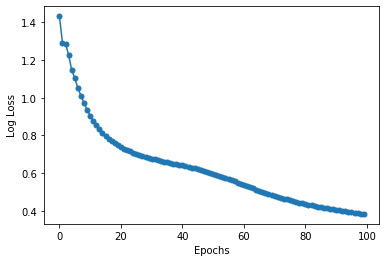

Training accuracy 0.8893
Validation accuracy 0.892
CPU times: user 354 ms, sys: 7.2 ms, total: 361 ms
Wall time: 360 ms


In [86]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

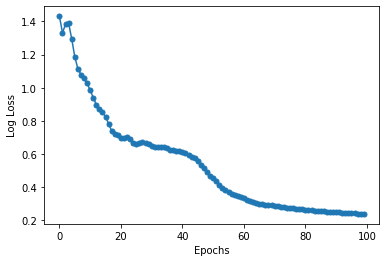

Training accuracy 0.908
Validation accuracy 0.936
CPU times: user 356 ms, sys: 10.6 ms, total: 367 ms
Wall time: 365 ms


In [87]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

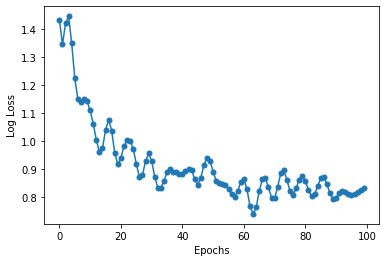

Training accuracy 0.62
Validation accuracy 0.628
CPU times: user 351 ms, sys: 9.14 ms, total: 360 ms
Wall time: 357 ms


In [88]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

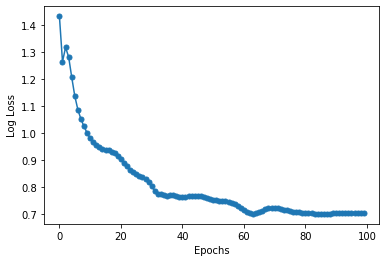

Training accuracy 0.664
Validation accuracy 0.668
CPU times: user 366 ms, sys: 11.1 ms, total: 377 ms
Wall time: 373 ms


In [89]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

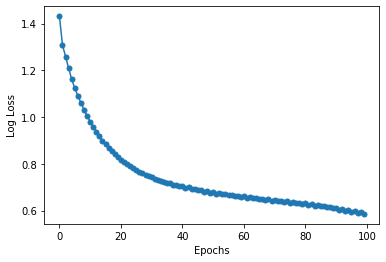

Training accuracy 0.8307
Validation accuracy 0.84
CPU times: user 334 ms, sys: 6.71 ms, total: 340 ms
Wall time: 342 ms


In [90]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

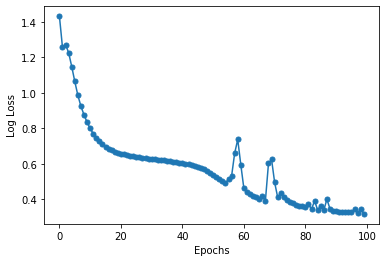

Training accuracy 0.8893
Validation accuracy 0.888
CPU times: user 349 ms, sys: 3.38 ms, total: 353 ms
Wall time: 375 ms


In [91]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

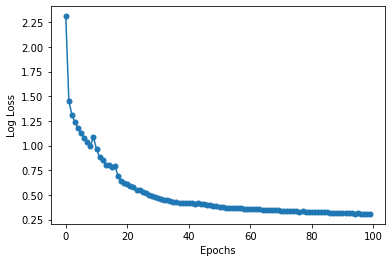

Training accuracy 0.896
Validation accuracy 0.908
CPU times: user 347 ms, sys: 4.75 ms, total: 352 ms
Wall time: 356 ms


In [92]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

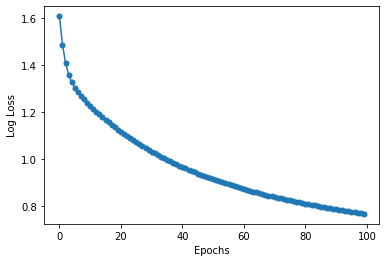

Training accuracy 0.7427
Validation accuracy 0.776
CPU times: user 343 ms, sys: 3.91 ms, total: 347 ms
Wall time: 350 ms


In [93]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

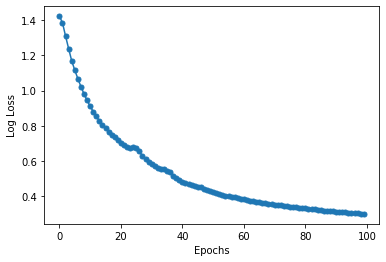

Training accuracy 0.888
Validation accuracy 0.904
CPU times: user 330 ms, sys: 6.96 ms, total: 337 ms
Wall time: 338 ms


In [94]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

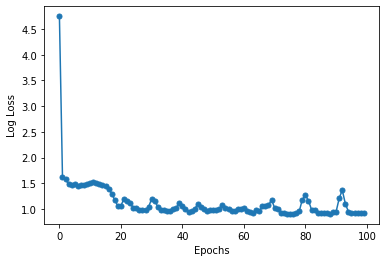

Training accuracy 0.5053
Validation accuracy 0.492
CPU times: user 354 ms, sys: 3.97 ms, total: 358 ms
Wall time: 358 ms


In [95]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

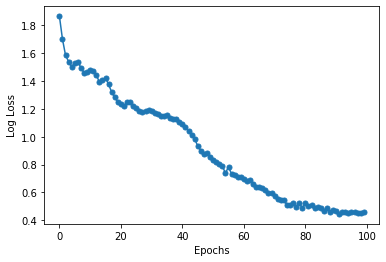

Training accuracy 0.8307
Validation accuracy 0.816
CPU times: user 343 ms, sys: 5.83 ms, total: 349 ms
Wall time: 349 ms


In [96]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

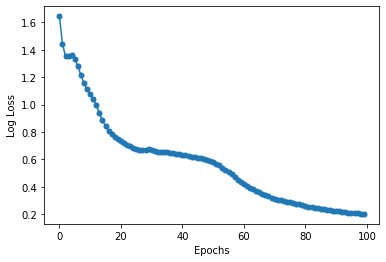

Training accuracy 0.924
Validation accuracy 0.94
CPU times: user 353 ms, sys: 4.88 ms, total: 358 ms
Wall time: 359 ms


In [97]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

#Good configurations with each algo

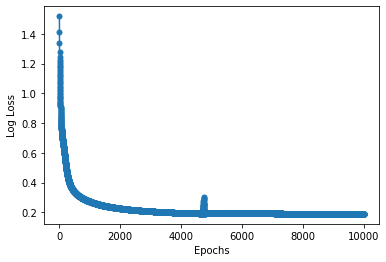

Training accuracy 0.928
Validation accuracy 0.932
CPU times: user 14.8 s, sys: 70 ms, total: 14.9 s
Wall time: 15 s


In [98]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()

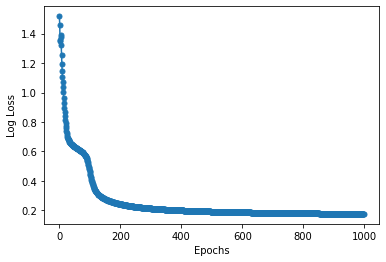

Training accuracy 0.9253
Validation accuracy 0.944
CPU times: user 1.69 s, sys: 11 ms, total: 1.7 s
Wall time: 1.7 s


In [99]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

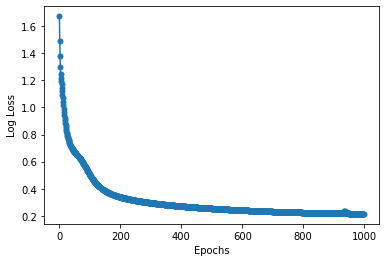

Training accuracy 0.912
Validation accuracy 0.94
CPU times: user 1.7 s, sys: 9.56 ms, total: 1.71 s
Wall time: 1.72 s


In [100]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

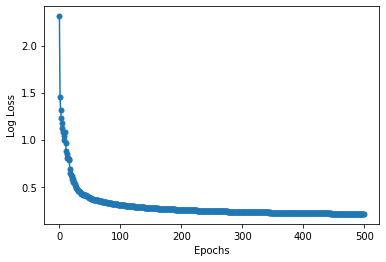

Training accuracy 0.9133
Validation accuracy 0.944
CPU times: user 940 ms, sys: 7.95 ms, total: 948 ms
Wall time: 950 ms


In [101]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

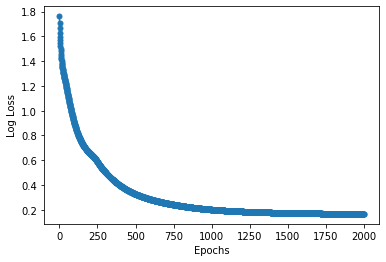

Training accuracy 0.928
Validation accuracy 0.944
CPU times: user 3.21 s, sys: 26.6 ms, total: 3.24 s
Wall time: 3.27 s


In [102]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

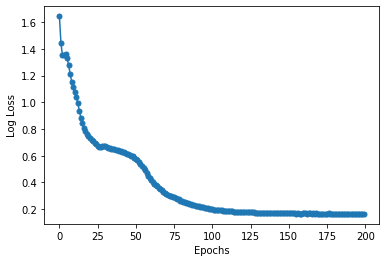

Training accuracy 0.9267
Validation accuracy 0.94
CPU times: user 531 ms, sys: 3.05 ms, total: 534 ms
Wall time: 530 ms


In [103]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()